# ASL Alphabet Classifier Test

#### Datasource: 
<a href="https://www.kaggle.com/grassknoted/asl-alphabet">https://www.kaggle.com/grassknoted/asl-alphabet</a>

<br>

This is a prototype, playing with FastAI using Resnet34 to classify American Sign Language alphabet.  It's basically Notebook #2 from the MOOC on a "clean" dataset.  We get great results ... but the data is really contrived.  It's highly likely the model will be overfitted, however it's a good test of the library.
<br>
<br>
<br>

In [1]:
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

RUN_NAME = '20210104 - Reboot Wandb'

import matplotlib.pyplot as plt
# set sensible default parameters for matplotlib
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastai

# trying weights and biases 

%env WANDB_WATCH=false

import wandb
from fastai.callback.wandb import *

wandb.init(project="asl-sign-language-recognition")
wandb.run.name = RUN_NAME

plt.style.use('dark_background')


env: WANDB_WATCH=false


wandb: Currently logged in as: cogsci2 (use `wandb login --relogin` to force relogin)


In [1]:
# from fastbook import *
# from fastai.vision.all import *
# from fastai.vision.widgets import *
# import fastai

In [2]:
path = '../data/external/Training Set'

<br>
<br>

## Check for an available GPU

In [3]:
import torch
print('CUDA available: '.ljust(28), torch.cuda.is_available())
print('CUDA device count: '.ljust(28), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device index: '.ljust(28), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(28), torch.cuda.get_device_name(current_device))

CUDA available:              True
CUDA device count:           1
Current CUDA Device index:   0
Current CUDA Device:         GeForce RTX 2070 SUPER


<br>
<br>

### Check for Dataset Imbalance

In [4]:
from string import ascii_uppercase
import numpy as np
import operator
import matplotlib.pyplot as plt

image_files = {}
image_files_qty = {}

# loop through all the characters to build dictionaries of image files and quartity of each category
for c, i in zip(ascii_uppercase, np.arange(len(ascii_uppercase))):
    image_files[c] = get_image_files(path + f'/{c}')
    l = len(image_files[c])
    image_files_qty[c] = l
    
# custom code since we don't use 'J'
image_files.pop('J')
image_files_qty.pop('J')

# Get the character with the largest and smallest number of entries
maxqc = max(image_files_qty, key=image_files_qty.get)
minqc = min(image_files_qty, key=image_files_qty.get)


print()
print(f'Character with the most images:   {maxqc},   #{image_files_qty[maxqc]}')
print(f'Character with the least images:  {minqc},   #{image_files_qty[minqc]}')





Character with the most images:   X,   #4901
Character with the least images:  Z,   #3001


<br>
<br>

## Display the number of image files for each category

Text(0, 0.5, 'Sample Size')

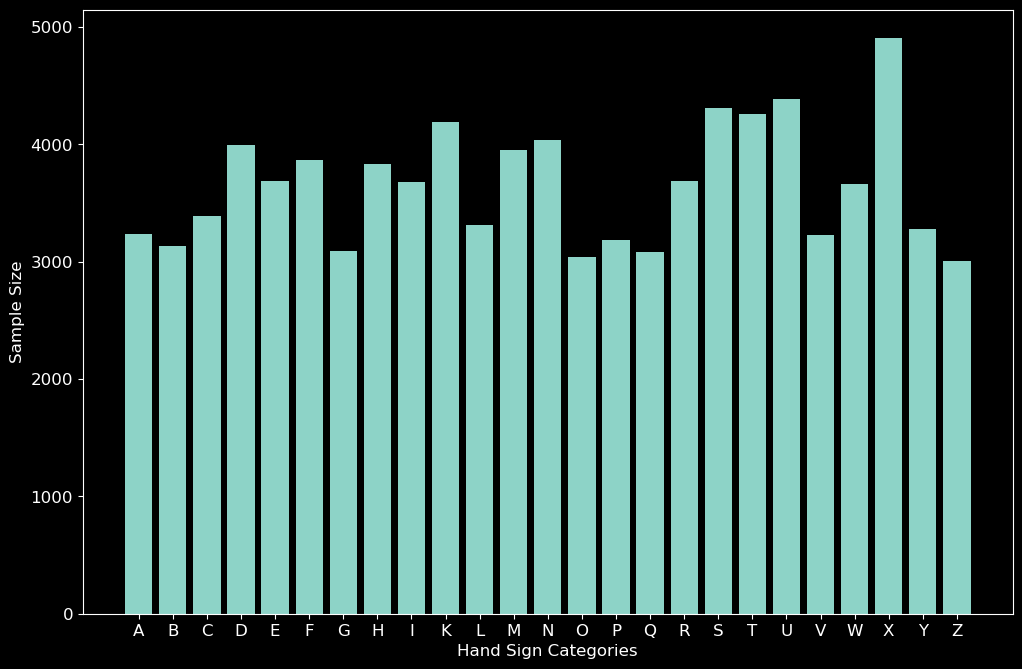

In [5]:
# plt.hist(image_files_qty.items)
plt.bar(image_files_qty.keys(), image_files_qty.values())
plt.xlabel('Hand Sign Categories')
plt.ylabel('Sample Size')

<br>
<br>

### Balance the Dataset with Oversampling or Undersampling

In [6]:
import pandas as pd

maxq = image_files_qty[maxqc] # the quantity of the largest category
minq = image_files_qty[minqc] # the quantity of the smallest category

CHOSEN_SAMPLE_SIZE = 3000 # use this to control sample sizes



all_image_files = pd.DataFrame(columns=[0])  # holds all the image files in one dataframe
new_image_files_qty = {}

for c, q in iter(image_files_qty.items()):
    df = pd.DataFrame(data=list(image_files[c]), columns=[0])  # create a dataframe from each list
    
#     if q < image_files_qty[maxqc]:
#         df = df.sample(maxq, replace=True).reset_index(drop=True) # oversample
#         all_image_files = pd.concat([all_image_files, df], ignore_index=True)

    # undersample or over sample as needed
    if len(df) >= CHOSEN_SAMPLE_SIZE:
        df = df.sample(CHOSEN_SAMPLE_SIZE, replace=False)  # undersample
    else:
        delta = CHOSEN_SAMPLE_SIZE - len(df)
        df = pd.concat([df, df.sample(delta, replace=(delta > len(df)))], ignore_index=True)  # overrsample
        
    # aggregate the image_files
    all_image_files = pd.concat([all_image_files, df], ignore_index=True)
    new_image_files_qty[c] = len(df)    
#     print(len(df))
    
# TEMPORARY @TODO remove this experiment
# all_image_files = all_image_files.sample(n=1000, replace=False)

all_image_files = all_image_files.sample(n = len(all_image_files))  # shuffle
    
# Needed to pass into the DataBlock    
def get_fnames(path): return list(all_image_files[0])

<br>
<br>

### Ensure the Dataset is Balanced

Text(0, 0.5, 'Sample Size')

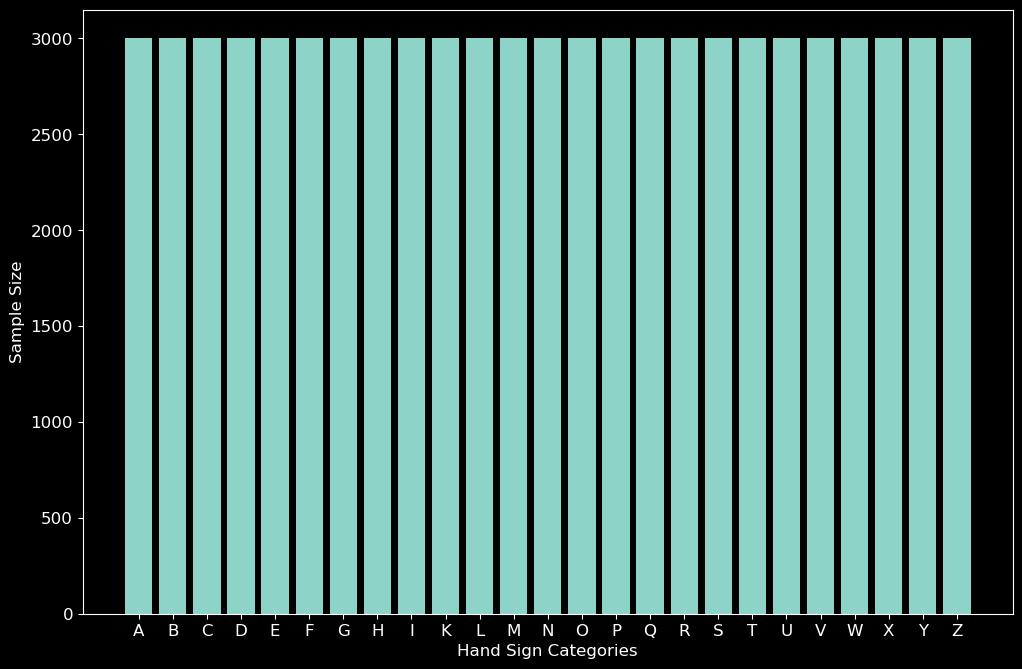

In [7]:
plt.bar(new_image_files_qty.keys(), new_image_files_qty.values())
plt.xlabel('Hand Sign Categories')
plt.ylabel('Sample Size')

<br>
<br>

<br>

### Create the DataBlock, while Resizing and Augmenting

In [8]:
signs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_fnames, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(384, method='bilinear'),
    batch_tfms=aug_transforms(size=384, do_flip=True, batch=True))

# learn_inf = load_learner('../models/export-resnet101-tune10un-tune2ft.pkl')



<br>
<br>

<br>

### Load the Data by Path

In [9]:
dls = signs.dataloaders(path, bs=12)
# wandb.log({'dataset':'../data/external/Trainiing Set'})

<br>

### Verify the Training and Validation Batches

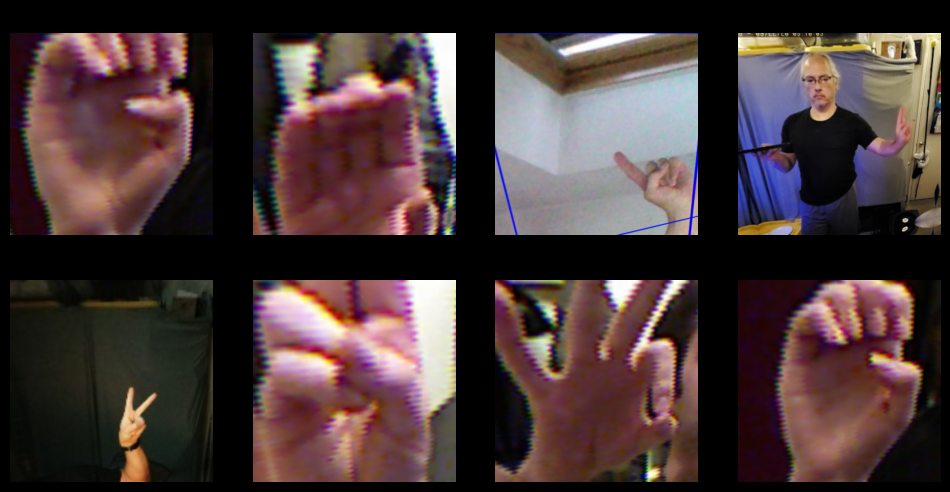

In [10]:
dls.train.show_batch(max_n=8, nrows=2)

<br>
<br>

### Define the model (Resnet34) and fit

In [11]:
# wandb.log()
learn = cnn_learner(dls, resnet50 , metrics=[error_rate, accuracy]) #  , \
Learner()
#                          SaveModelCallback()])
# learn = cnn_learner(data, models.densenet121, metrics=[accuracy, top_k_accuracy], callback_fns=[WandbCallback])

<br>
<br>

### Look at the Loss Function, Optimization Function and Model Architecture

In [12]:
print('\n', learn.loss_func)
print(learn.opt_func)
print('\n\n', learn.model)


 FlattenedLoss of CrossEntropyLoss()
<function Adam at 0x7f38091beef0>


 Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(in

<br>
<br>
<br>

## Manually find a learning rate between the shoulder and the steepest drop.

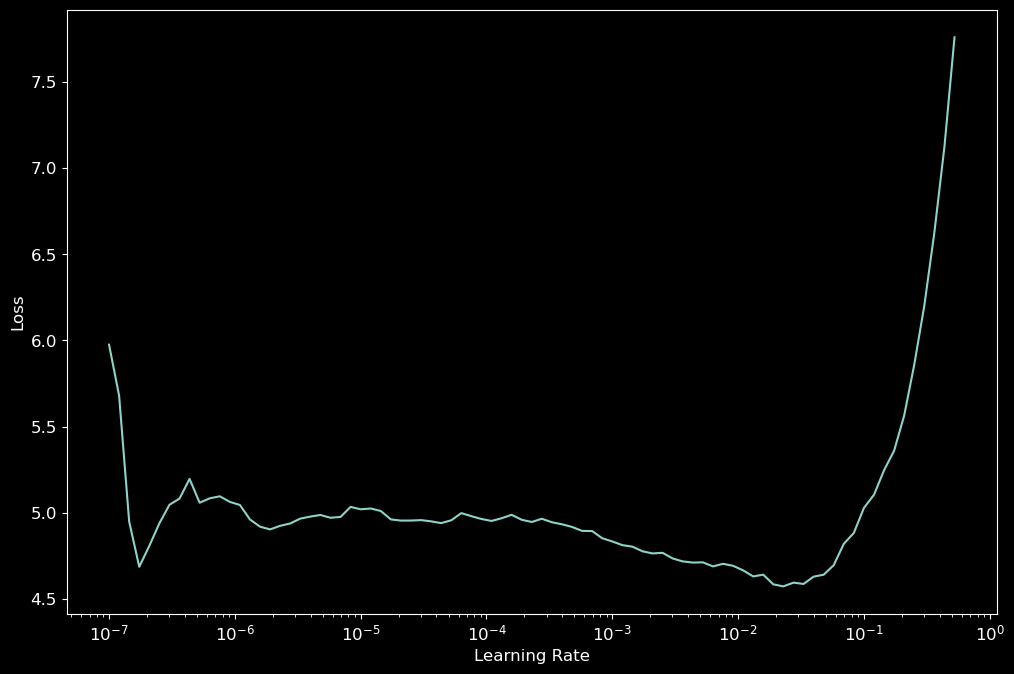

In [13]:
lr_min,lr_steep = learn.lr_find()

In [14]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 2.29e-03, steepest point: 1.10e-06


<br>
<br>
<br>

## Create an Early Stopping Callback

In [15]:
early_stop = EarlyStoppingCallback(monitor='error_rate', min_delta=0.00075, patience=3)
wandb_cb = WandbCallback(log_dataset=False, log_model=True, log='all')


<br>
<br>

## Fit the last layer, unfreeze, fit the whole net, with a descriminant LR, all in one go.
Model architecture: resnet101 @ 384px <br>
Filename: ../models/201001-1400-RESNET101-384px-FALL-ft2.pkl


In [16]:
# Enable auto logging
# mlflow.fastai.autolog()

# Start MLflow session
# with mlflow.start_run():
    # Train and fit with default or supplied command line arguments
# learn.fine_tune(7, freeze_epochs=4, base_lr=1e-4, bs=12, cbs=early_stop)
learn.fine_tune(10, base_lr=10e-3, cbs=[early_stop, wandb_cb, SaveModelCallback()])
# learn.fine_tune(9, base_lr=10e-4, cbs=[early_stop])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.752291,0.208611,0.065600,0.934400,23:54


Better model found at epoch 0 with valid_loss value: 0.2086111605167389.


wandb: Adding directory to artifact (/tmp/tmplt6fnqhz)... Done. 0.2s


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.344048,0.197314,0.062867,0.937133,32:12
1,0.370943,0.151106,0.048267,0.951733,32:12
2,0.267761,0.206646,0.018733,0.981267,32:12
3,0.267188,5.907344,0.040467,0.959533,33:03
4,0.207338,0.228682,0.014800,0.985200,32:13
5,0.083571,1.106337,0.012133,0.987867,32:13
6,0.080657,5.812692,0.017000,0.983000,32:31
7,0.044688,0.429848,0.005667,0.994333,33:33
8,0.022603,0.204655,0.002333,0.997667,32:52
9,0.021409,0.309125,0.003267,0.996733,32:41


Exception ignored in: <finalize object at 0x7f3800f72ce0; dead>
Traceback (most recent call last):
  File "/home/frank/miniconda3/envs/learn/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/home/frank/miniconda3/envs/learn/lib/python3.7/tempfile.py", line 797, in _cleanup
    _shutil.rmtree(name)
  File "/home/frank/miniconda3/envs/learn/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/home/frank/miniconda3/envs/learn/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmplt6fnqhz'


Better model found at epoch 0 with valid_loss value: 0.19731377065181732.
Better model found at epoch 1 with valid_loss value: 0.15110646188259125.


wandb: Adding directory to artifact (/tmp/tmpbubxqms2)... Done. 0.2s


In [17]:
#learn.fit_one_cycle(2, 4e-2)

<br>
<br>

<br>

### Plot Losses

Text(0.5, 0, 'Batches Processed')

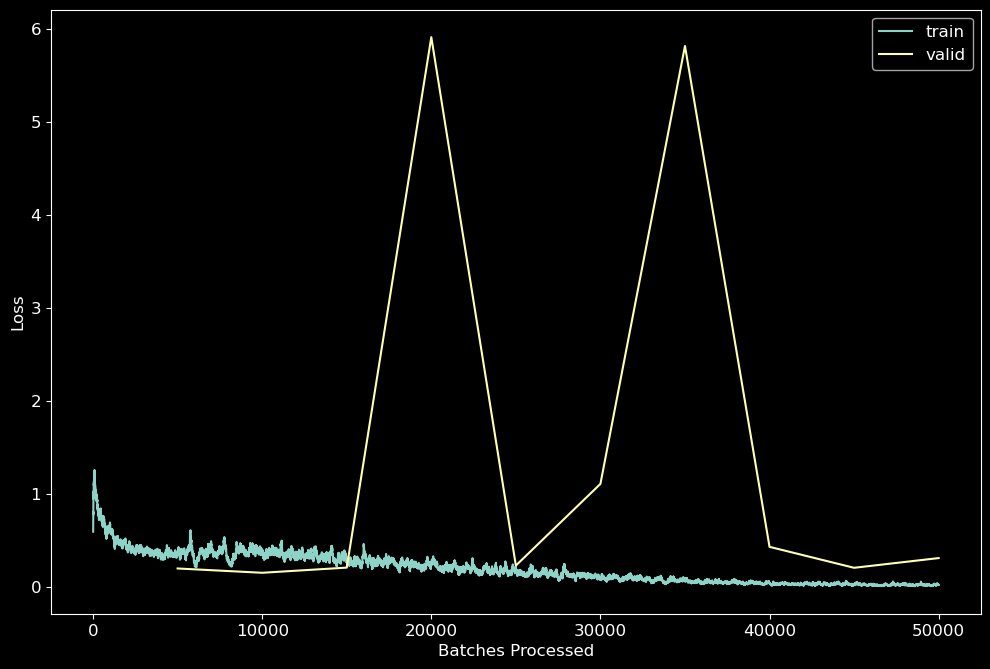

In [18]:
learn.recorder.plot_loss()
plt.ylabel('Loss')
plt.xlabel('Batches Processed')

<br>

### Visualize with a confusion Matrix

In [ ]:
## @TODO after updating FastAI and WandB, this cell interrupts the kernel somehow

interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix(figsize=(8,8))

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

<br>

### Show the top 5 most error prone images

In [ ]:
interp.plot_top_losses(15, nrows=3)

<br>

### ~~Clean the images that were hard to interpret and obviously bad~~

(I had to remove this section as it was using too much RAM and crashing the kernel)

In [ ]:
# cleaner = ImageClassifierCleaner(learn)
# cleaner

<br>
<br>
<hr>
<br>
<br>

## Persist the Model



In [1]:
learn.export(f'../models/{RUN_NAME}.pkl')
path = Path('../models')
path.ls(file_exts='.pkl')

NameError: name 'learn' is not defined

In [ ]:
# learn.save(os.path.join(wandb.run.dir, "20210103a.h5"))

In [ ]:
# learn.save(os.path.join(wandb.run.dir, "20210103.h5"))

In [ ]:
# learn.save("model.h5")

In [ ]:
# wandb.run.path


In [ ]:
# %cd ..
# learn_inf.save('save/200921-0201-export-resnet101-FALL-tune2ft-tune6un-tune2ft-F-t2ft-ut3-t2ft-t2ft')
# %cd notebooks

<br>
<br>
<br>

## Clean up

<br>

In [ ]:
# wandb.join()

In [ ]:
# wandb.finish()

<br>
<br>
<br>
<hr>
<br>

# Log

* started to plot the learning rates and started to use that information while fitting.
* Downgraded to resnet34 @ 300px in order to increase the resolution fed to the model from 128px to 300px - this made a major difference.
* Decreased the number of training epochs to 6 after experimenting to find the sweet spot. - also positive change
* Changed to exclusively use fine-tune() with it's built in freeze_epochs parameter
* Changed the Batch Size in order to bring the arch back to resnet101 @300px
* Cleaned up the markdown, removed cells and reordered the rest.
* Added an Early Stop.  Starting with 0.01 delta.  
* Now moving to 0.1 delta
* Integrated wandb to keep track of experiments.
* added section to balance the dataset through oversampling.

** Attempting a batch size of 12 and 384px with resnet101.  long training times.
** Also increased the epochs to 4 on the final layer and 7 on the rest.
    